# Hazard assessment for windstorms


Click [![STORMS](https://img.shields.io/badge/STORMS-repository-blue)](https://github.com/CLIMAAX/STORMS) to go to this workflow's GitHub repository.

This event-based windstorm workflow can be used to see damages of a storm by combining hazard, exposure and vulnerability. The workflow is a simplified version of the work by [Koks & Haer (2020)](https://doi.org/10.1038/s41598-020-63580-w). Here the hazard is represented by a map with the maximum 3-second wind gust of a storm.

## Hazard data
Using the Copernicus Climate Data store, [historical storm footprints](https://doi.org/10.24381/cds.9b4ea013) can be retrieved. Next to that, [synthetic storms footprints](https://doi.org/10.24381/cds.ce973f02) can be found that are physically realistic and thus plausible storms. These synthetic storms can be useful to create a larger overview of possible events that can affect the area in current-day situations. Both datasets give the footprints of the maximum 3-second gust per 72 hours per grid cell.  

The workflow also demonstrates how to move historical storm footprints to different locations. This allows us to test the impact of storms happening further south of the original location. We do this because climate models suggest that future storms are likely to shift further north.

## Preparation work

### Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the datasets for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results.

In [1]:
## name the area for saving datasets and plots# specify the coordinates of the bounding box
bbox = [-8.811,42.6647,-7.1524,43.8009] # Barcelona, Spain
areaname = 'DeLugo_Spain'

# Examples:
# bbox = [-1.6,46,-1.05,46.4]; areaname = 'La_Rochelle'
#bbox = [1.983871,41.252461,2.270614,41.449569]; areaname = 'Barcelona'
#bbox = [12.1,45.1,12.6,45.7]; areaname = 'Venice'
#bbox = [-9.250441,38.354403,-8.618666,38.604761]; areaname = 'Setubal'

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [zipfile](https://docs.python.org/3/library/zipfile.html#zipfile-objects) - To download and unzip the data
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [matplotlib](https://matplotlib.org/) - To plot results
- [cdsapi](https://cds-beta.climate.copernicus.eu/how-to-api) - To download data from the Copernicus Data Store 
- [geopandas](https://geopandas.org/en/stable/#) - To work with geospatial shapes
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot country borders
- [shapely](https://shapely.readthedocs.io/en/stable/index.html#) - To convert coordinates of area to a shape that can be plotted 

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.
`````

In [2]:
import os
from zipfile import ZipFile
import xarray as xr
import matplotlib.pyplot as plt
import cdsapi
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box


### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'STORM_event_raster' in the same directory where this notebook is saved.

In [3]:
# Define the folder for the storm workflow
workflow_folder = 'STORM_event_raster'

# Check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

general_data_folder = os.path.join(workflow_folder, 'general_data')

# Check if the general data folder exists, if not, create it
if not os.path.exists(general_data_folder):
    os.makedirs(general_data_folder)

In [4]:
# Define directories for data and plots within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Download and view a single storm event

First we need the information on the hazard we want to analyse. In this workflow we will start by downloading a storm in Spain from the historical [wind storm data set](https://doi.org/10.24381/cds.9b4ea013). In the "Download data" tab select "widstorm footprints" and select one of the available dates.

Alternatively, you can also use the code below and download the data using the API provided by the Climate Data Store. Be sure to register an account and obtain the userid and the api key to place below

In [5]:
day = '24'
month = '01'
year = '2009'
storm_name = 'Klaus'

In [ ]:
URL = 'https://cds-beta.climate.copernicus.eu/api'
KEY = None #add your own
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'sis-european-wind-storm-indicators',
    {
        'variable': 'all',
        'format': 'zip',
        'product': 'windstorm_footprints',
        'year': year,
        'month': month,
        'day': day,
    },
    f'{general_data_folder}/{storm_name}.zip'
)

To check the dataset we open the file

Text(0.5, 1.0, 'Windstorm across Europe')

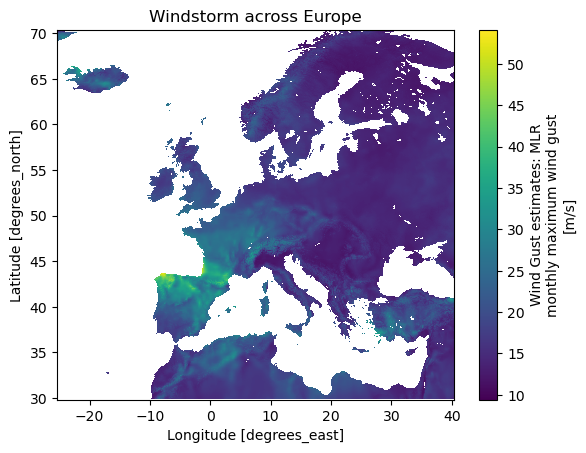

In [6]:
with ZipFile(f"{general_data_folder}/{storm_name}.zip") as zf:

    # Let's get the filename first
    file = zf.namelist()[0]

    # And now we can open and select the file within Python
    with zf.open(file) as f:
        windstorm_europe = xr.open_dataset(f)

windstorm_europe = windstorm_europe.rename({'Latitude': 'y','Longitude': 'x'})
windstorm_europe = windstorm_europe.rio.set_spatial_dims(x_dim="x",y_dim="y", inplace=True)

windstorm_europe.rio.write_crs(4326, inplace=True)

windstorm_europe = windstorm_europe['FX']['z'==1]

#plot
windstorm_europe.plot()
plt.title('Windstorm across Europe')

In the plot above you can see the high windspeeds of the storm light up in yellow across Europe and especially the northwest of the Iberian peninsula.

Now we will clip the dataset to a wider area around the region of interest, and call it *windstorm_region*. The clipping of the dataset allows to reduce the total size of the dataset so that it can be loaded into memory for faster processing and plotting.

In [7]:
windstorm_region = windstorm_europe.rio.clip_box(*bbox, crs="EPSG:4326")

# we delete the map variable to save computing resources for later
del windstorm_europe

# save the data as nc file
windstorm_region.to_netcdf(f'{data_dir}/{storm_name}.nc')

In [8]:
windstorm_region.rio.resolution()

(0.016665899999999567, -0.01666670000000181)

Text(0.5, 1.0, 'Windstorm Klaus across the region')

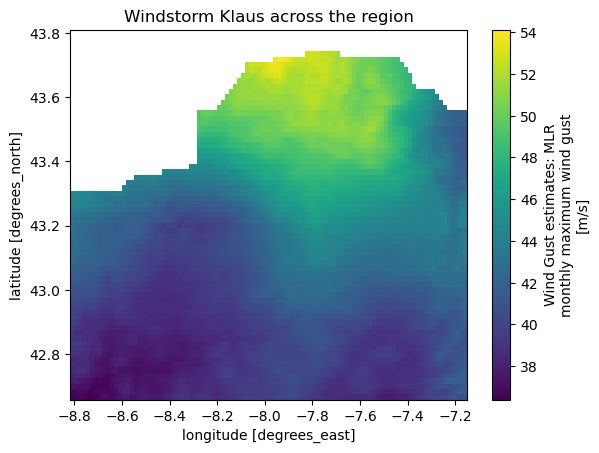

In [9]:
windstorm_region.plot()

#set title
plt.title(f'Windstorm {storm_name} across the region')

Here we will shift the storm footprint to a new location and save it for further use in the risk assement section worflow

In [10]:
# Calculate the current center of the footprint
current_center_lat = (windstorm_region['y'].min().item() + windstorm_region['y'].max().item()) / 2
current_center_lon = (windstorm_region['x'].min().item() + windstorm_region['x'].max().item()) / 2

print(f"Current center of footprint: Lat={current_center_lat}, Lon={current_center_lon}")

# Define the desired center (for example, coordinates in Southern France)
desired_center_lat = 43.499415 # Latitude, replace with your desired location
desired_center_lon = -1.4727   # Longitude, replace with your desired location

print(f"Desired center in France: Lat={desired_center_lat}, Lon={desired_center_lon}")

# Step 3: Calculate the translation vector (shift)
lat_shift = desired_center_lat - current_center_lat
lon_shift = desired_center_lon - current_center_lon

# Step 4: Apply the shift to the dataset
windstorm_region_shifted = windstorm_region.assign_coords(
    x=windstorm_region['x'] + lon_shift,  # Shift x (longitude) by lon_shift
    y=windstorm_region['y'] + lat_shift   # Shift y (latitude) by lat_shift
)

Current center of footprint: Lat=43.23359980000145, Lon=-7.982913150000435
Desired center in France: Lat=43.499415, Lon=-1.4727


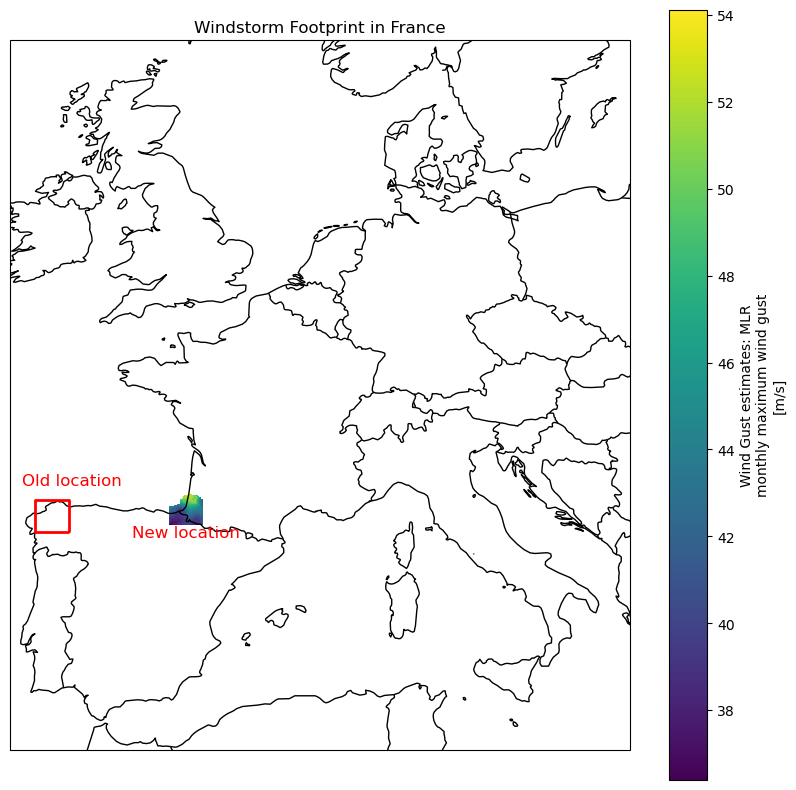

In [11]:
# Extract latitude and longitude coordinates from the shifted windstorm footprint data
lats = windstorm_region_shifted['x'].values  # Extract latitude values from the shifted data
lons = windstorm_region_shifted['y'].values  # Extract longitude values from the shifted data

# Create a plot of the European map with the updated windstorm footprint
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographic reference features such as coastlines and country borders
ax.coastlines()  # Add coastlines to the map for better geographic context
ax.add_feature(cfeature.BORDERS)  # Add country borders to the map

# Plot the shifted windstorm footprint on the map using the 'viridis' color map
windstorm_region_shifted.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', label='Moved windstorm footprint')

# Add a label indicating the new location of the windstorm footprint
plt.text(desired_center_lon, desired_center_lat - 1, 'New location', color='red', fontsize=12, ha='center')

# Set the extent of the map to focus on the region of interest (adjust limits as necessary)
ax.set_extent([-10, 20, 35, 60], crs=ccrs.PlateCarree())

# Add a title to the plot to describe the windstorm footprint location
plt.title('Windstorm Footprint in France')

# Plot the original bounding box of the windstorm footprint for comparison
bbox_old = gpd.GeoSeries([box(*bbox)], crs='EPSG:4326')  # Create a GeoSeries for the old bounding box
bbox_old.boundary.plot(ax=ax, color='red', linewidth=2)  # Plot the old bounding box with a red outline

# Add a label indicating the old location of the windstorm footprint
plt.text(current_center_lon + 1, current_center_lat + 1.1, 'Old location', color='red', fontsize=12, ha='center')

# Display the final plot
plt.show()


In [12]:
# save the foorprint
windstorm_region_shifted.to_netcdf(f'{data_dir}/{storm_name}_shifted.nc')

## Conclusions

In this hazard workflow we learned:
 - How to retrieve winstorm footprints for your specific region.
 - How to move winstorms more north to asses potential future hazards.
 
The regional windstorm map can now be used in the risk assessment workflow.


## Contributors

**Authors**: 
- Ted Buskop (Deltares & Vrije Universiteit Amsterdam, IVM)

**References**: 

- Koks, E.E., Haer., T. A high-resolution wind damage model for Europe. Sci Rep 10, 6866 (2020). https://doi.org/10.1038/s41598-020-63580-w

- Copernicus Climate Change Service, Climate Data Store, (2022): Winter windstorm indicators for Europe from 1979 to 2021 derived from reanalysis. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.9b4ea013 

- Copernicus Climate Change Service, Climate Data Store, (2022): Synthetic windstorm events for Europe from 1986 to 2011. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.ce973f02